In [450]:
import pandas as pd
import numpy as np
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torch import as_tensor
from torch.nn.init import *

import time
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path
import random

import re
from pandas.api.types import is_string_dtype, is_numeric_dtype
import warnings

# import sklearn
# from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve
from sklearn.metrics import auc, plot_precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import plotly.graph_objs as go

import sys

Please check the related data at https://www.cosmos11.osdinfra.net/cosmos/MMRepository.Prod/local/users/jiafa/relevant_classifier/

In [369]:
df_logo = pd.read_table('placeholder_logo_feat.tsv', sep = "\t")

In [370]:
df_nonlogo = pd.read_table('Rankfile_BasicEncoding_20230523_LogoClassifier.tsv', sep = "\t")
df_nonlogo = df_nonlogo[df_nonlogo['Dist'] > 150]

In [371]:
df_logo['LogoLabel'] = 1
df_nonlogo['LogoLabel'] = 0
df_all = pd.concat([df_logo, df_nonlogo])

In [372]:
df_all = df_all.groupby('LogoLabel').sample(10000)

In [373]:
df_all.columns

Index(['SIEMv3ImageEncoded_Binary', 'MUrl', 'PUrl', 'PKey', 'Key', 'ClusterId',
       'Dist', 'MediaFeat', 'RelevantScore', 'RelevantOrder', 'IsOgImage',
       'PostRelevantScore', 'DisplayXDim', 'DisplayYDim', 'DupCount',
       'MMR_DuMmFlags', 'MMR_DU_ImgTag', 'MMR_DU_Hyperlink',
       'MMR_DU_MetaOGTag', 'MMR_DU_MetaTwitterTag', 'MMR_DU_WrapStar',
       'Basic__UrlEncodings', 'UrlMLScore', 'LogoLabel', 'Weight',
       'SIEMv3ImageEncoded'],
      dtype='object')

In [28]:
from torch.utils.data import Dataset
import numpy as np
import os
import torch
from torchvision import transforms
from random import uniform

In [374]:
df_all = df_all[['MUrl', 'PUrl', 'Basic__UrlEncodings', 'LogoLabel']]

In [375]:
df_all['Basic__UrlEncodings_arr'] = df_all['Basic__UrlEncodings'].apply(lambda x: [float(y) for y in x.split()][:100] + [0]*(100 - len(x.split())))

In [376]:
Basic__UrlEncodings_columns = ['col' + str(i) for i in range(100)]

In [378]:
df_all[Basic__UrlEncodings_columns] = df_all['Basic__UrlEncodings_arr'].apply(pd.Series)

C:\Users\huangxingli\Anaconda3\lib\site-packages\pandas\core\frame.py:3641: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [380]:
df_all.drop(['Basic__UrlEncodings', 'Basic__UrlEncodings_arr'], inplace = True, axis = 1)

In [401]:
def TrainModel(df_train, df_test, training_features, params, num_boost_round = 2000):
    X_train = df_train[training_features]
    X_test = df_test[training_features]
    y_train = df_train['LogoLabel']
    y_test = df_test['LogoLabel']
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    #metrics = lgb.cv(params, train_data)
    evals_result={}
    model = lgb.train(params,
                train_data,
                num_boost_round=num_boost_round,
                valid_sets=[train_data, test_data],
                evals_result=evals_result,
                verbose_eval=10,
                early_stopping_rounds=50)
    y_pred = model.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    auc_precision_recall = auc(recall, precision)

    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple', label="AUC="+str(auc_precision_recall))

    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.ylim([0, 1.05])
    plt.xlim([0, 1.05])

    #add auc	 
    ax.text(0.8,0.9,s="AUC="+str(round(auc_precision_recall,2)))

    print("finished drawing")
    lgb.plot_importance(model, figsize=(20, 20))
    importances = model.feature_importance()
    feat_importances = list(zip(training_features,importances))
    feat_importances.sort(key=lambda x: -x[1])
    print(feat_importances)
    return model, feat_importances, evals_result

In [382]:
training_features = Basic__UrlEncodings_columns

In [435]:
model = lgb.LGBMRegressor()

# Define the parameter grid
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [2000],
    'num_leaves':[8],
    'feature_fraction': [0.08, 0.05, 0.1],
    'bagging_fraction':[0.5],
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid=param_grid, cv=3)
grid_search.fit(train[training_features], train['LogoLabel'])
# Print the best parameters and score



[LightGBM] [Warning] feature_fraction is set=0.08, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.08, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.05, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.05, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'bagging_fraction': [0.5],
                         'feature_fraction': [0.08, 0.05, 0.1],
                         'learning_rate': [0.1], 'n_estimators': [2000],
                         'num_leaves': [8]})

In [436]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'bagging_fraction': 0.5, 'feature_fraction': 0.05, 'learning_rate': 0.1, 'n_estimators': 2000, 'num_leaves': 8}
Best score: 0.5488155157579141


In [437]:
paramsGrid = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss', 'error'],
    'num_leaves': 8,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'verbose': 0,
    'n_estimators': 2000
}


In [386]:
train, test = train_test_split(df_all, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

C:\Users\huangxingli\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

C:\Users\huangxingli\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\huangxingli\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

C:\Users\huangxingli\Anaconda3\lib\site-packages\lightgbm\engine.py:260: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005749 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.802314	training's binary_logloss: 0.583381	valid_1's auc: 0.785684	valid_1's binary_logloss: 0.592173
[20]	training's auc: 0.827373	training's binary_logloss: 0.53998	valid_1's auc: 0.810122	valid_1's binary_logloss: 0.553259
[30]	training's auc: 0.842909	training's binary_logloss: 0.511884	valid_1's auc: 0.824001	valid_1's binary_logloss: 0.529181
[40]	training's auc: 0.858676	training's binary_logloss: 0.487866	valid_1's auc: 0.840582	valid_1's binary_logloss: 0.507492
[50]	training's auc: 0.869035	training's binary_logloss: 0.470336	valid_1's auc: 0.849706	valid_1's binary_logloss: 0.493431
[60]	training's auc: 0.878761	training's binary_logloss: 0.455454	valid_1's auc: 0.858636	valid_1's binary_logloss: 0.48064
[70]	training's auc: 0.885

[650]	training's auc: 0.979829	training's binary_logloss: 0.226568	valid_1's auc: 0.917161	valid_1's binary_logloss: 0.358605
[660]	training's auc: 0.980391	training's binary_logloss: 0.224815	valid_1's auc: 0.917125	valid_1's binary_logloss: 0.358539
[670]	training's auc: 0.980655	training's binary_logloss: 0.223098	valid_1's auc: 0.917334	valid_1's binary_logloss: 0.357647
[680]	training's auc: 0.981093	training's binary_logloss: 0.221387	valid_1's auc: 0.917647	valid_1's binary_logloss: 0.356957
[690]	training's auc: 0.981318	training's binary_logloss: 0.219985	valid_1's auc: 0.917721	valid_1's binary_logloss: 0.356899
[700]	training's auc: 0.981796	training's binary_logloss: 0.21867	valid_1's auc: 0.91767	valid_1's binary_logloss: 0.357199
[710]	training's auc: 0.982172	training's binary_logloss: 0.217046	valid_1's auc: 0.917637	valid_1's binary_logloss: 0.356995
[720]	training's auc: 0.982419	training's binary_logloss: 0.215478	valid_1's auc: 0.917868	valid_1's binary_logloss: 0.3

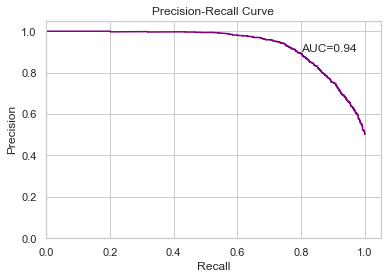

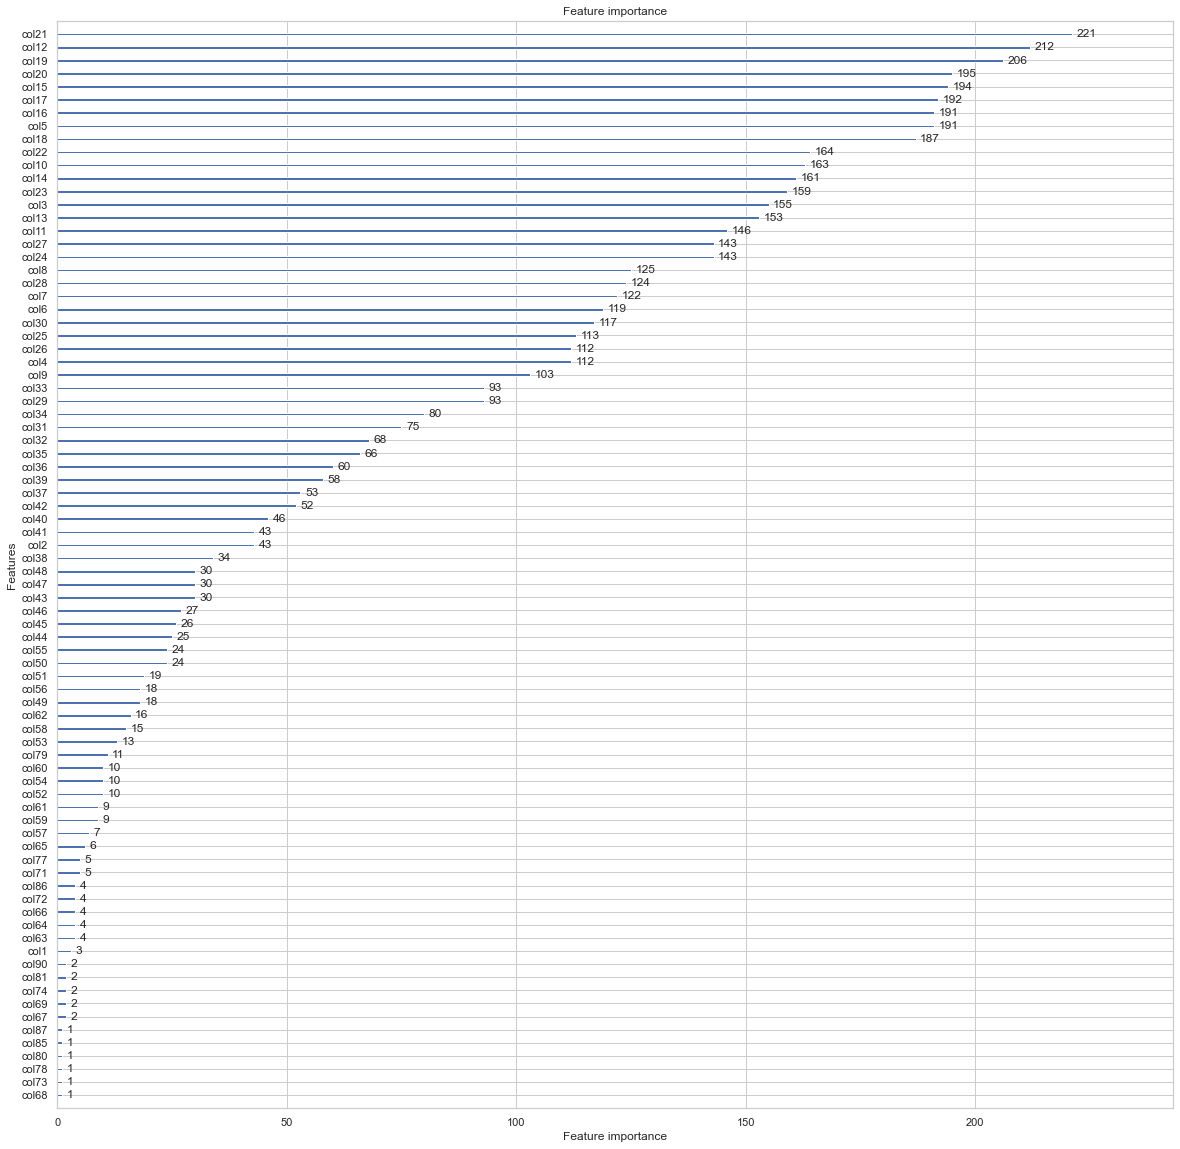

In [438]:
import lightgbm as lgb
model, feat_importances, evals_result = TrainModel(train, val, training_features, paramsGrid, num_boost_round = 2000)

In [442]:
pred = model.predict(test[training_features])

In [424]:
evals_result

{'training': OrderedDict([('auc',
               [0.7876789407092823,
                0.8053721080032937,
                0.8069206089579828,
                0.8158378836334119,
                0.8183921234642554,
                0.8208339851898206,
                0.8223788850646642,
                0.8294873556443056,
                0.8357457516535182,
                0.841464132170519,
                0.8430278675240117,
                0.8462560952243675,
                0.8505503035942243,
                0.8536435091109518,
                0.8577062840137251,
                0.8613922150659611,
                0.8642718338231778,
                0.8673878909381109,
                0.8688857326339572,
                0.871711164294788,
                0.8732314547561794,
                0.8751583742708973,
                0.8780264085373571,
                0.8799075516133619,
                0.8812835181187784,
                0.8827826415549087,
                0.88517637088104

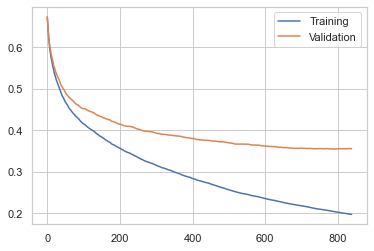

In [439]:
train_metric = evals_result['training']['binary_logloss']
val_metric = evals_result['valid_1']['binary_logloss']
plt.plot(train_metric, label='Training')
plt.plot(val_metric, label='Validation')
plt.legend()
plt.show()


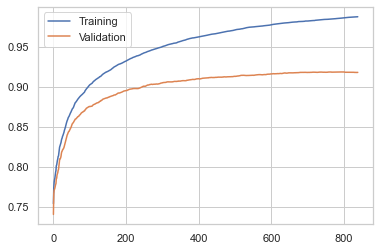

In [440]:
train_metric = evals_result['training']['auc']
val_metric = evals_result['valid_1']['auc']
plt.plot(train_metric, label='Training')
plt.plot(val_metric, label='Validation')
plt.legend()
plt.show()

Text(0.8, 0.9, 'AUC=0.93')

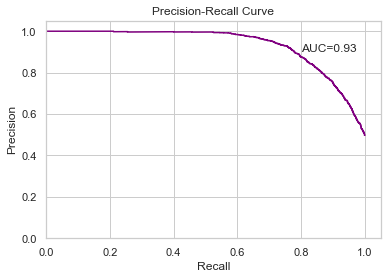

In [455]:
precision1, recall1, thresholds1 = precision_recall_curve(test['LogoLabel'], pred)

fig, ax = plt.subplots()
ax.plot(recall1, precision1, color='purple', label="AUC="+str(auc(recall1, precision1)))
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.ylim([0, 1.05])
plt.xlim([0, 1.05])
ax.text(0.8,0.9,s="AUC="+str(round(auc(recall1, precision1),2)))

(0.0, 1.05)

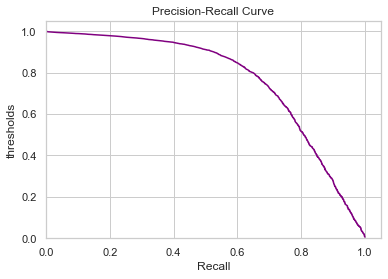

In [479]:
precision1, recall1, thresholds1 = precision_recall_curve(test['LogoLabel'], pred)

fig, ax = plt.subplots()
ax.plot(recall1[:-1], thresholds1 , color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('thresholds')
ax.set_xlabel('Recall')
plt.ylim([0, 1.05])
plt.xlim([0, 1.05])


In [457]:
test['LogoScore'] = pred

In [480]:
test['Pred_LogoLabel'] = test['LogoScore'] > 0.5

In [481]:
test[['MUrl', 'PUrl', 'LogoScore', 'LogoLabel', 'Pred_LogoLabel']].to_csv("LogoClassifierResult.tsv", sep = "\t")

In [456]:
model.save_model('LogoClassifier_model.txt')

In [419]:
model = lgb.LGBMRegressor()

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.02, 0.03],
    'n_estimators': [100, 200, 300, 400],
    'num_leaves': [20, 30, 40, 50]
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid=param_grid, cv=3)
grid_search.fit(train[training_features], train['LogoLabel'])


GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.02, 0.03],
                         'n_estimators': [100, 200, 300, 400],
                         'num_leaves': [20, 30, 40, 50]})

In [420]:
# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 400, 'num_leaves': 20}
Best score: 0.5105022448829076
